In [1]:
# Import statements
import json
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import scipy
import skimage as sk
import re

<h1>Part 1</h1>

In [2]:
# Open the images
hailey = skio.imread("../images/hailey.jpg") / 255
george = skio.imread("../images/george.jpg") / 255

# Opening JSON file
f = open('hailey_george.json',)
   
# returns JSON object as 
# a dictionary
data = json.load(f)

im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

assert(len(im1_points) == len(im2_points))
   
# Closing file
f.close()

In [3]:
# Compute the mean of the two point sets
mean_points = (im1_points + im2_points)/2
# print(mean_points.shape)
# print(mean_points)

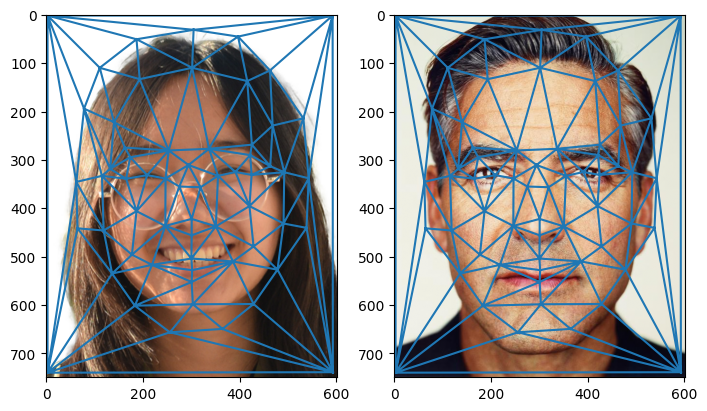

In [4]:
# Create triangulation on the images
triangulation = scipy.spatial.Delaunay(mean_points)
triangles = triangulation.simplices

plt.figure(figsize=(8, 4), layout="compressed")
plt.subplot(121); plt.triplot(mean_points[:,0], mean_points[:,1], triangulation.simplices); plt.gca().invert_yaxis(); plt.imshow(hailey)
plt.subplot(122); plt.triplot(mean_points[:,0], mean_points[:,1], triangulation.simplices); plt.gca().invert_yaxis(); plt.imshow(george)

In [5]:
# print(triangles.shape)
# print(triangles)

<h1>Part 2</h1>

In [6]:
def computeAffine(tri1_pts, tri2_pts):
    assert(len(tri1_pts[0]) == 3)
    assert(len(tri1_pts) == 2)
    # Should take you from triangle T1 to T2
    T1 = np.vstack([tri1_pts[0], tri1_pts[1], np.ones(3)])
    T2 = np.vstack([tri2_pts[0], tri2_pts[1], np.ones(3)])

    T1_inv = np.linalg.inv(T1)

    # print("affine transformation matrix")
    res = np.matmul(T2, T1_inv)
    # print(res)

    return res

T1
[[0 0]
 [0 3]
 [7 0]]
T2
[[2 0]
 [1 3]
 [9 2]]
A
[[ 1.         -0.33333333  2.        ]
 [ 0.28571429  1.          0.        ]
 [ 0.          0.          1.        ]]
Matrix
[[0. 0. 7.]
 [0. 3. 0.]
 [1. 1. 1.]]
[[2. 1. 9.]
 [0. 3. 2.]
 [1. 1. 1.]]


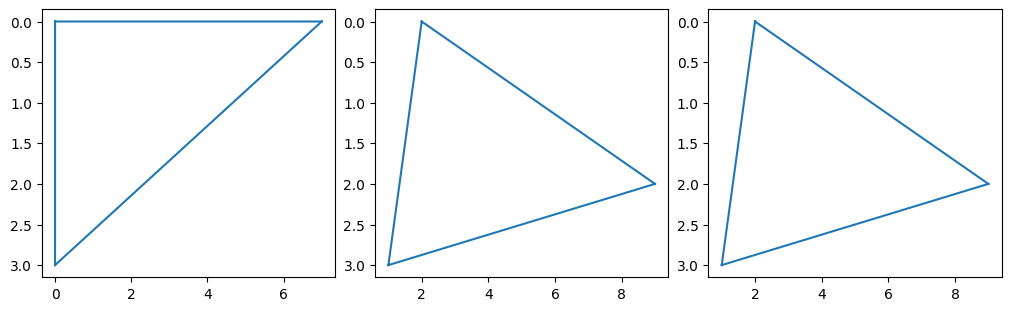

In [7]:
# Sanity Check: Warp 1 triangle into another

tri_points = np.matrix([[0, 0], [0, 3], [7, 0]])
single_triang = scipy.spatial.Delaunay(tri_points)
# print(single_triang.simplices)

tri_points1 = np.matrix([[2, 0], [1, 3], [9, 2]])
single_triang1 = scipy.spatial.Delaunay(tri_points1)

print("T1")
print(tri_points)
print("T2")
print(tri_points1)

A = computeAffine([[0,0,7], [0,3,0]], [[2,1,9], [0,3,2]])
print("A")
print(A)

print("Matrix")
new_tri_points = np.stack([np.ravel(tri_points[:,0]), np.ravel(tri_points[:,1]), np.ones(3)])
print(new_tri_points)

assert(np.all(new_tri_points[2,:] == np.ones(3)))

new_T2 = np.matmul(A, new_tri_points)
print(new_T2)
x = np.ravel(new_T2[0,:])
y = np.ravel(new_T2[1,:])
# print(x)
# print(y)

plt.figure(figsize=(10, 3), layout="compressed")
plt.subplot(131); plt.triplot([0,0,7], [0,3,0], single_triang.simplices); plt.gca().invert_yaxis()
plt.subplot(132); plt.triplot([2,1,9], [0,3,2], single_triang1.simplices); plt.gca().invert_yaxis()
plt.subplot(133); plt.triplot(x, y, single_triang.simplices); plt.gca().invert_yaxis()

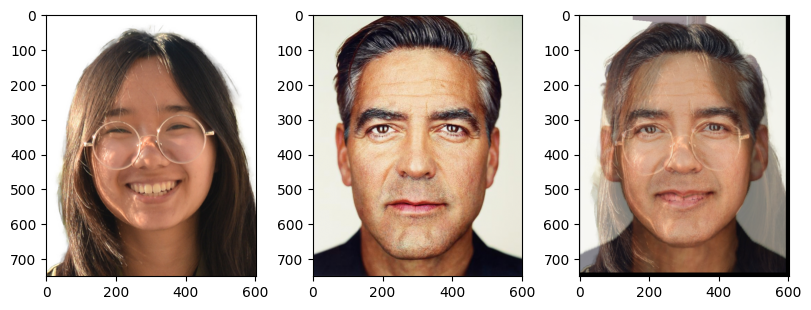

In [8]:
# Compute the avg shape
avg_img = np.zeros(hailey.shape)
avg_shape = ((0.5) * im1_points) + (0.5 * im2_points)

# Transform the triangles from img -> avg shape
for i in range(len(triangles)):
    # Get the indices of the vertices
    a, b, c = triangles[i]
    # print("indices of triangles:", a, b, c)

    # Get the x,y coords of the triangle's vertices
    im1_tri_pts = [np.array([im1_points[a][0], im1_points[b][0], im1_points[c][0]]), np.array([im1_points[a][1], im1_points[b][1], im1_points[c][1]])]
    im2_tri_pts = [np.array([im2_points[a][0], im2_points[b][0], im2_points[c][0]]), np.array([im2_points[a][1], im2_points[b][1], im2_points[c][1]])]
    avg_tri_pts = [np.array([avg_shape[a][0], avg_shape[b][0], avg_shape[c][0]]), np.array([avg_shape[a][1], avg_shape[b][1], avg_shape[c][1]])]
    # print("triangle coords:", im1_tri_pts, im2_tri_pts, avg_tri_pts)

    # Compute Affine transformations
    im1_avg_aff = computeAffine(im1_tri_pts, avg_tri_pts)
    im2_avg_aff = computeAffine(im2_tri_pts, avg_tri_pts)

    # print("im1")
    # print(im1_avg_aff.shape)
    # print(im1_avg_aff)

    # print("im2")
    # print(im2_avg_aff.shape)
    # print(im2_avg_aff)

    # im1 triangle polygon
    im1_tri_poly_x, im1_tri_poly_y = sk.draw.polygon([im1_tri_pts[0][0], im1_tri_pts[0][1], im1_tri_pts[0][2]], [im1_tri_pts[1][0], im1_tri_pts[1][1], im1_tri_pts[1][2]])

    # print(im1_tri_poly_x.shape)
    # print(im1_tri_poly_x)

    # im2 triangle polygon
    im2_tri_poly_x, im2_tri_poly_y = sk.draw.polygon([im2_tri_pts[0][0], im2_tri_pts[0][1], im2_tri_pts[0][2]], [im2_tri_pts[1][0], im2_tri_pts[1][1], im2_tri_pts[1][2]])

    # Create the polygon
    avg_poly_x, avg_poly_y = sk.draw.polygon([avg_tri_pts[0][0], avg_tri_pts[0][1], avg_tri_pts[0][2]], [avg_tri_pts[1][0], avg_tri_pts[1][1], avg_tri_pts[1][2]])
    avg_polygon_matrix = np.vstack([avg_poly_x, avg_poly_y, np.ones(len(avg_poly_x))])

    assert(np.all(avg_polygon_matrix[2,:] == np.ones(avg_polygon_matrix.shape[1])))

    # print(im1_avg_aff.shape)
    # print(np.linalg.inv(im1_avg_aff).shape)
    # print(avg_polygon_matrix.shape)
    # print(avg_polygon_matrix)

    # Multiply the polygon with the inverse affine transform matrix, T1 = A^(-1) @ T2
    im1_inv_warp = np.matmul(np.linalg.inv(im1_avg_aff), avg_polygon_matrix)
    im2_inv_warp = np.matmul(np.linalg.inv(im2_avg_aff), avg_polygon_matrix)

    # print(im1_inv_warp.shape)
    # print(im1_inv_warp)

    # Remove the 1s from the matrix to get x,y coords
    im1_inv_warp_coords = np.delete(im1_inv_warp, 2, 0).T
    im2_inv_warp_coords = np.delete(im2_inv_warp, 2, 0).T

    # print("im1 inv warp coords:", im1_inv_warp_coords.shape)
    # print(im1_inv_warp_coords)

    # Separate color channels
    im1_rgb_coords = np.array((im1_tri_poly_x, im1_tri_poly_y)).T
    im2_rgb_coords = np.array((im2_tri_poly_x, im2_tri_poly_y)).T

    im1_rgb = hailey[im1_tri_poly_y, im1_tri_poly_x,:]
    im2_rgb = george[im2_tri_poly_y, im2_tri_poly_x,:]

    # print(im1_rgb_coords.shape)
    # print(im1_rgb.shape)

    # Interpolate the img with the inverse warps: inv warp -> original
    im1_interp = scipy.interpolate.griddata(im1_rgb_coords, im1_rgb, im1_inv_warp_coords, method="nearest")
    im2_interp = scipy.interpolate.griddata(im2_rgb_coords, im2_rgb, im2_inv_warp_coords, method="nearest")

    # print(im1_interp.shape)
    # print(im2_interp.shape)

    # Set image values with the new interpolated values
    avg_img[avg_poly_y, avg_poly_x] = ((0.5) * im1_interp) + (0.5 * im2_interp)

plt.figure(figsize=(8, 4), layout="compressed")
plt.subplot(131); plt.imshow(hailey)
plt.subplot(132); plt.imshow(george)
plt.subplot(133); plt.imshow(avg_img)

<h1>Part 3</h1>

In [76]:
def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    # Compute the weighted shape
    res = np.zeros(im1.shape)
    weighted_points = ((1 - warp_frac) * im1_pts) + (warp_frac * im2_pts)
    triangles = tri.simplices

    # print(weighted_points.shape)

    # Transform the triangles from img -> weighted_tri_pts
    for i in range(len(triangles)):
        # Get the indices of the vertices
        a, b, c = triangles[i]
        # print("indices of triangles:", a, b, c)

        # Get the x,y coords of the triangle's vertices
        im1_tri_pts = [np.array([im1_pts[a][0], im1_pts[b][0], im1_pts[c][0]]), np.array([im1_pts[a][1], im1_pts[b][1], im1_pts[c][1]])]
        im2_tri_pts = [np.array([im2_pts[a][0], im2_pts[b][0], im2_pts[c][0]]), np.array([im2_pts[a][1], im2_pts[b][1], im2_pts[c][1]])]
        weighted_tri_pts = [np.array([weighted_points[a][0], weighted_points[b][0], weighted_points[c][0]]), np.array([weighted_points[a][1], weighted_points[b][1], weighted_points[c][1]])]
        # print("triangle coords:", im1_tri_pts, im2_tri_pts, weighted_tri_pts)

        # Compute Affine transformations
        im1_avg_aff = computeAffine(im1_tri_pts, weighted_tri_pts)
        im2_avg_aff = computeAffine(im2_tri_pts, weighted_tri_pts)

        # print("im1")
        # print(im1_avg_aff.shape)
        # print(im1_avg_aff)

        # print("im2")
        # print(im2_avg_aff.shape)
        # print(im2_avg_aff)

        # im1 triangle polygon
        im1_tri_poly_x, im1_tri_poly_y = sk.draw.polygon([im1_tri_pts[0][0], im1_tri_pts[0][1], im1_tri_pts[0][2]], [im1_tri_pts[1][0], im1_tri_pts[1][1], im1_tri_pts[1][2]])

        # print(im1_tri_poly_x.shape)
        # print(im1_tri_poly_x)

        # im2 triangle polygon
        im2_tri_poly_x, im2_tri_poly_y = sk.draw.polygon([im2_tri_pts[0][0], im2_tri_pts[0][1], im2_tri_pts[0][2]], [im2_tri_pts[1][0], im2_tri_pts[1][1], im2_tri_pts[1][2]])

        # Create the polygon
        weighted_poly_x, weighted_poly_y = sk.draw.polygon([weighted_tri_pts[0][0], weighted_tri_pts[0][1], weighted_tri_pts[0][2]], [weighted_tri_pts[1][0], weighted_tri_pts[1][1], weighted_tri_pts[1][2]])
        weighted_polygon_matrix = np.vstack([weighted_poly_x, weighted_poly_y, np.ones(len(weighted_poly_x))])

        assert(np.all(weighted_polygon_matrix[2,:] == np.ones(weighted_polygon_matrix.shape[1])))

        # print(im1_avg_aff.shape)
        # print(np.linalg.inv(im1_avg_aff).shape)
        # print(weighted_polygon_matrix.shape)
        # print(weighted_polygon_matrix)

        # Multiply the polygon with the inverse affine transform matrix, T1 = A^(-1) @ T2
        im1_inv_warp = np.matmul(np.linalg.inv(im1_avg_aff), weighted_polygon_matrix)
        im2_inv_warp = np.matmul(np.linalg.inv(im2_avg_aff), weighted_polygon_matrix)

        # print(im1_inv_warp.shape)
        # print(im1_inv_warp)

        # Remove the 1s from the matrix to get x,y coords
        im1_inv_warp_coords = np.delete(im1_inv_warp, 2, 0).T
        im2_inv_warp_coords = np.delete(im2_inv_warp, 2, 0).T

        # print("im1 inv warp coords:", im1_inv_warp_coords.shape)
        # print(im1_inv_warp_coords)

        # Separate color channels
        im1_rgb_coords = np.array((im1_tri_poly_x, im1_tri_poly_y)).T
        im2_rgb_coords = np.array((im2_tri_poly_x, im2_tri_poly_y)).T

        im1_rgb = im1[im1_tri_poly_y, im1_tri_poly_x,:]
        im2_rgb = im2[im2_tri_poly_y, im2_tri_poly_x,:]

        # print(im1_rgb_coords.shape)
        # print(im1_rgb.shape)

        # Interpolate the img with the inverse warps: inv warp -> original
        im1_interp = scipy.interpolate.griddata(im1_rgb_coords, im1_rgb, im1_inv_warp_coords, method="nearest")
        im2_interp = scipy.interpolate.griddata(im2_rgb_coords, im2_rgb, im2_inv_warp_coords, method="nearest")

        # print(im1_interp.shape)
        # print(im2_interp.shape)

        # Set image values with the new interpolated values
        res[weighted_poly_y, weighted_poly_x] = ((1 - dissolve_frac) * im1_interp) + (dissolve_frac * im2_interp)

    # Return weighted image
    return res

In [10]:
seq = []

for i in np.arange(0, 1, 0.05):
    seq.append(morph(hailey, george, im1_points, im2_points, triangulation, i, (1-i)))

print(len(seq))
for i in range(len(seq)):
    im_out = sk.img_as_ubyte(seq[i])
    fname = '../images/out_path/fm' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

20


<h1>Part 4</h1>

In [77]:
# All of the female images in the Danes dataset
imgs = []
# x,y coords of the correspondence points in each image
img_pts = []
# Get the numbers of the image names whose subjects are female
female_imgs = ["08", "12", "14", "15", "22", "30", "35"]

# Iterate through each female image and get the x,y coords
for i in range(len(female_imgs)):
    img = skio.imread("../images/danes/" + female_imgs[i] + "-1f.jpg") / 255

    # Store the img
    imgs.append(img)

    # Initialize with 4 corner coords
    x_pts = [0, img.shape[1]-1, 0, img.shape[1]-1]
    y_pts = [img.shape[0]-1, img.shape[0]-1, 0, 0]

    file_name = female_imgs[i] + "-1f.asf" # Parse the .asf files

    file = open("../images/danes/" + file_name, "r")
    lines = file.readlines()

    # Extract x,y coords using Regex
    for line in lines:
        matching = re.findall("(\d\.\d{8})", line)
        if (matching):
            x_pts.append(float(matching[0]) * img.shape[1])
            y_pts.append(float(matching[1]) * img.shape[0])

    if (x_pts and y_pts):
        img_pts.append(np.column_stack((x_pts, y_pts)))

# print(len(imgs))
# print(len(img_pts))
# print(img_pts[0])

assert(len(imgs) == len(img_pts))

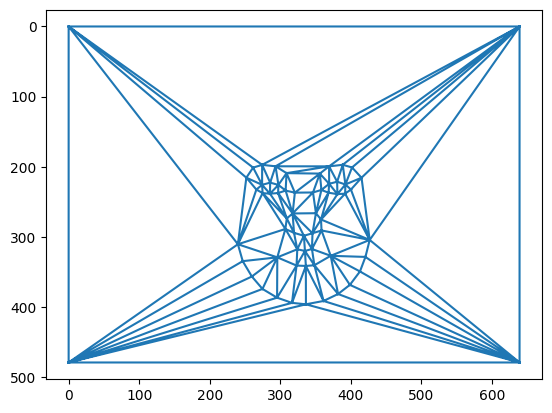

In [78]:
# Compute the mean of the points
img_pt_sum = img_pts[0]
for i in range(1, len(img_pts)):
    img_pt_sum = img_pt_sum + img_pts[i]

img_pt_mean = img_pt_sum / len(img_pts)
# print(img_pt_mean)

# Create triangulation on the images
f_triangulation = scipy.spatial.Delaunay(img_pt_mean)
f_triangles = f_triangulation.simplices

plt.triplot(img_pt_mean[:,0], img_pt_mean[:,1], f_triangles); plt.gca().invert_yaxis()

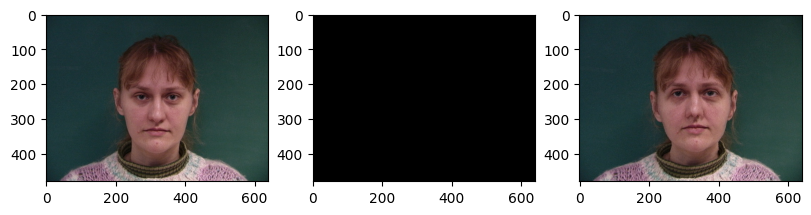

In [82]:
# Test one morph to the average shape

assert(imgs[0].shape == imgs[1].shape)
assert(img_pts[0].shape == img_pts[1].shape)
test = morph(imgs[0], np.zeros(imgs[0].shape), img_pts[0], img_pt_mean, f_triangulation, 1, 0)

plt.figure(figsize=(8, 4), layout="compressed")
plt.subplot(131); plt.imshow(imgs[0])
plt.subplot(132); plt.imshow(np.zeros(imgs[0].shape))
plt.subplot(133); plt.imshow(test)

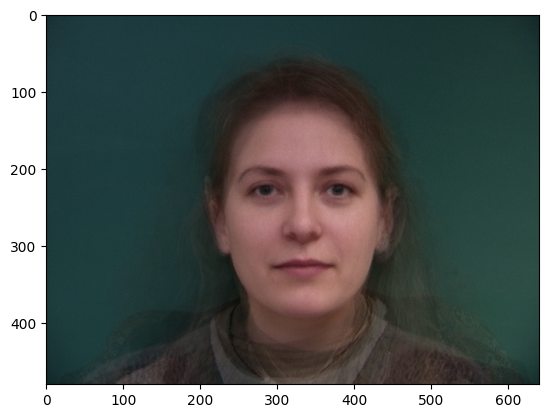

In [86]:
# Blend all of the morphed faces together to get the average face
average_face = np.zeros(imgs[0].shape)

# Save all of the morphs to the average shape
for i in range(len(imgs)):
    m = morph(imgs[i], np.zeros(imgs[i].shape), img_pts[i], img_pt_mean, f_triangulation, 1, 0)
    average_face += (m / len(imgs))
    im_out = sk.img_as_ubyte(m)
    fname = '../images/out_path/f_to_avg/morph' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

plt.imshow(average_face)

im_out = sk.img_as_ubyte(average_face)
fname = '../images/out_path/f_to_avg/avg_face.jpg'
skio.imsave(fname, im_out)

(750, 602, 3)
[[  0. 479.]
 [639. 479.]
 [  0.   0.]
 [639.   0.]]
[[  0.          85.85714286]
 [107.          85.85714286]
 [  0.           0.        ]
 [107.           0.        ]]
[[  0.          85.85714286]
 [107.          85.85714286]
 [  0.           0.        ]
 [107.           0.        ]
 [239.8640576  310.44911794]
 [246.70737646 334.55635817]
 [259.63363657 356.44304709]
 [274.69815589 374.16088046]
 [295.40322651 386.63118926]
 [316.52764891 394.02477737]
 [336.25115977 396.06105463]
 [361.23732846 391.30213989]
 [381.81796663 381.37950034]
 [398.55068617 368.34706834]
 [412.83640686 349.26583611]
 [420.59216091 328.52200457]
 [426.6244224  304.32262766]
 [400.03917166 232.48437394]
 [392.20506971 225.20571497]
 [380.49999909 221.33605029]
 [369.16359497 224.28436594]
 [358.19585371 233.03718583]
 [368.33410103 236.99898446]
 [380.86866743 239.02595314]
 [391.83640046 238.28887269]
 [266.02995566 232.48437051]
 [274.14055497 225.75852206]
 [285.56912366 222.62593714]
 [29

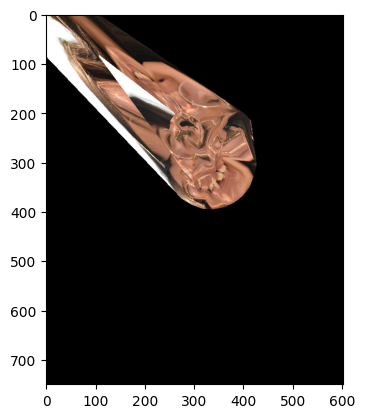

In [122]:
# My face warped into the average geometry
sixty_two_corr = np.matrix.copy(im1_points)
sixty_two_corr = np.append(sixty_two_corr, np.array([(310, 300)]), axis=0)
# print(sixty_two_corr.shape)
# print(sixty_two_corr)

modified_avg_face = skio.imread('../images/avg_face.jpg') / 255
print(modified_avg_face.shape)

print(img_pt_mean[0:4])

modified_pt_mean = np.matrix.copy(img_pt_mean)
modified_pt_mean[0] = [0, 601 / len(img_pts)]
modified_pt_mean[1] = [749 / len(img_pts), 601 / len(img_pts)]
modified_pt_mean[3] = [749 / len(img_pts), 0]

print(modified_pt_mean[0:4])
print(modified_pt_mean)

my_to_avg = morph(hailey, modified_avg_face, sixty_two_corr, modified_pt_mean, f_triangulation, 1, 0)

plt.imshow(my_to_avg)